In [103]:
# 9,CongestionWindow
# 17,SmoothedRTT
# 20,RetransmissionTimeout
# 21,SocketSendBufferSize
# 22,SocketSendBufferBytes
# 23,SocketReceiveBufferSize
# 24,SocketReceiveBufferBytes
# 25,UnacknowledgedBytes

# # With ECN and no ECN

In [104]:
import numpy as np
import matplotlib.pyplot as plt
import time
import pandas as pd
import matplotlib.pyplot as plt
# from gym import wrappers
# from gym import spaces
import math
import random
import re
import os
import sys
import seaborn as sns

In [105]:
col = ['Direction', 
        'Time', 
        'LocalIP', 
        'LocalPort',
        'ForeignIP',
        'ForeignPort', 
        'SlowStartThreshold', 
        'CongestionWindow', 
        'BandwidthControlledWindow', 
        'SendingWindow', 
        'ReceiveWindow', 
        'SendingWindowScalingFactor', 
        'ReceiveWindowScalingFactor', 
        'TCPFiniteStateMachine',
        'MaximumSegmentSize', 
        'SmoothedRTT', 
        'SACKEnabled', 
        'TCPFlags', 
        'RetransmissionTimeout', 
        'SocketSendBufferSize', 
        'SocketSendBufferBytes', 
        'SocketReceiveBufferSize', 
        'SocketReceiveBufferBytes', 
        'UnacknowledgedBytes', 
        'ReassemblyQueue', 
        'Flowid', 
        'Flowtype']

In [106]:
col[15]

'SmoothedRTT'

In [107]:
import os

file_path = './Old/V2_2_Queue_with_weights_L4S_Cubic_vs_DCTCP'


if os.path.exists(file_path):
    print("The path exists.")
else:
    print("The path does not exist.")


The path does not exist.


In [108]:
import os

def functionfilenameandpath(paths=['./'], extension='.log'):
    filepaths = []
    filenames = []
    filedict={}
    for path in paths:
        for root, _, files_list in os.walk(path):
            for file_name in files_list:
                if file_name.endswith(extension):
                    file_name_path = os.path.join(root, file_name)
                    filenames.append(file_name)
                    filepaths.append(file_name_path)
                    filedict[file_name]=file_name_path

    return filenames, filepaths , filedict

# Example usage with a list of folder paths
mainpth="./"
# mainpth="./Old/V2_2_Queue_with_weights_L4S_Cubic_vs_DCTCP"
folderpaths = [mainpth+'./client1_data',mainpth+'./client2_data']
filenames, filepaths, filedict = functionfilenameandpath(folderpaths, '.log')

filepaths.sort()
filenames.sort()
print(filenames)


['l4s_10Mbps_20ms_ecn_dctcp_src2.siftr.log', 'l4s_10Mbps_20ms_ecn_newreno_src1.siftr.log']


In [109]:
filedict

{'l4s_10Mbps_20ms_ecn_newreno_src1.siftr.log': '././client1_data\\l4s_10Mbps_20ms_ecn_newreno_src1.siftr.log',
 'l4s_10Mbps_20ms_ecn_dctcp_src2.siftr.log': '././client2_data\\l4s_10Mbps_20ms_ecn_dctcp_src2.siftr.log'}

In [110]:
unique_scenarios_dict={}
for index in range(len(filenames)):
    scenario = "_".join(filenames[index].split('_')[:4])
    if scenario in unique_scenarios_dict:
        unique_scenarios_dict[scenario].append(filedict[filenames[index]])
    else:
        unique_scenarios_dict[scenario]=[filedict[filenames[index]]]


In [111]:
unique_scenarios_dict.keys()

dict_keys(['l4s_10Mbps_20ms_ecn'])

In [112]:
def remove_outliers_iqr(df, column_name):
    """
    Remove outliers from a specified column in a DataFrame using the IQR method.
    
    Parameters:
    df (pd.DataFrame): The DataFrame.
    column_name (str): The name of the column from which to remove outliers.
    
    Returns:
    pd.DataFrame: The DataFrame with outliers removed.
    """
    Q1 = df[column_name].quantile(0.25)
    Q3 = df[column_name].quantile(0.75)
    IQR = Q3 - Q1
    
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    
    return df[(df[column_name] >= lower_bound) & (df[column_name] <= upper_bound)]

In [113]:
import pandas as pd
import re
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.ticker as ticker


# Function to calculate statistics for a DataFrame
def calculate_statistics(tcp1,tcp2,dftcp1,dftcp2,column):
    return {
        str(tcp1 + ' Median'): str(dftcp1[column].median()),
        str(tcp1 + ' Mean'): str(dftcp1[column].mean()),
        str(tcp1 + ' 25th Percentile'): str(dftcp1[column].quantile(0.25)),
        str(tcp1 + ' 75th Percentile'): str(dftcp1[column].quantile(0.75)),
        str(tcp1 + ' Minimum'): str(dftcp1[column].min()),
        str(tcp1 + ' Maximum'): str(dftcp1[column].max()),
        'Separator': str("==================================================="),
        str(tcp2 + ' Median'): str(dftcp2[column].median()),
        str(tcp2 + ' Mean'): str(dftcp2[column].mean()),
        str(tcp2 + ' 25th Percentile'): str(dftcp2[column].quantile(0.25)),
        str(tcp2 + ' 75th Percentile'): str(dftcp2[column].quantile(0.75)),
        str(tcp2 + ' Minimum'): str(dftcp2[column].min()),
        str(tcp2 + ' Maximum'): str(dftcp2[column].max()),
    }

# Function to save statistics to a file
def save_statistics_to_file(stats_filename, statistics, title):
    with open(stats_filename, 'a') as f:
        f.write(f"Statistics for {title}:\n")
        for key, value in statistics.items():
            f.write(f"{key}: {value}\n")
        f.write("\n")

# Function to format y-axis labels with commas
def comma_format(x, pos):
    return f'{int(x):,}'

# Darker color-blind-friendly palette
colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728']
colors = ['r','b']


In [114]:
def get_dataframe_from_filepath(logpath):
    data = []
    with open(logpath, 'r') as f:
        for line in f:
            cleaned_line = re.sub(r'\s', '', line)
            data.append(cleaned_line.split(','))
    
    # Remove header and footer lines
    print(logpath)
    data.pop(0)
    data.pop(-1)

    df = pd.DataFrame(data, columns=col)

    # Filter and process data
    df = df[df['Direction'] == 'o'].astype({'CongestionWindow': 'int32', 'Time': 'float64'})
    df['Time'] -= df['Time'].iloc[0]
    df['SmoothedRTT'] = df['SmoothedRTT'].astype('float64') / 1000
    return df

In [115]:
# df=get_dataframe_from_filepath(filepaths[10])
# df['ForeignPort'].unique()

In [116]:
df=get_dataframe_from_filepath(filepaths[1])
df['ForeignPort'].unique()

././client2_data\l4s_10Mbps_20ms_ecn_dctcp_src2.siftr.log


array(['54522', '54504', '54530', '5102', '54552'], dtype=object)

In [117]:
import os

def create_directory_if_not_exists(directory_path):
    """Create a directory if it doesn't already exist."""
    if not os.path.exists(directory_path):
        os.makedirs(directory_path)
        print(f"Directory created: {directory_path}")
    else:
        print(f"Directory already exists: {directory_path}")

# # Example usage
# directory_path = './Old/V2_2_Queue_with_weights_L4S_Cubic_vs_DCTCP/Graphs'
# create_directory_if_not_exists(directory_path)


def manage_file(filename: str, directory: str = "./") -> str:
    """
    Ensures that the file for the given scenario exists.
    If the directory or file does not exist, they are created.
    If the file exists, it is deleted and recreated.

    Args:
        filename (str): The name of the file to be created or managed.
        directory (str): The directory where the file should be created.

    Returns:
        str: The path of the file.
    """
    # Construct the directory path and file path
    file_path = os.path.join(directory, filename)
    
    # Create the directory if it does not exist
    if not os.path.exists(directory):
        os.makedirs(directory)  # Create the directory (and intermediate directories if necessary)

    # Check if the file exists and remove it if it does
    if os.path.exists(file_path):
        os.remove(file_path)  # Delete the file

    # Create (or recreate) the file
    with open(file_path, 'w') as file:
        pass  # Open file in write mode to create it if it does not exist

    return file_path

././client1_data\l4s_10Mbps_20ms_ecn_newreno_src1.siftr.log
././client2_data\l4s_10Mbps_20ms_ecn_dctcp_src2.siftr.log
DCTCP-NEWRENO
NEWRENO
   Direction      Time     LocalIP LocalPort   ForeignIP ForeignPort  \
90         o  4.754542  172.16.3.2     36797  172.16.1.2        5101   
91         o  4.755200  172.16.3.2     36797  172.16.1.2        5101   
93         o  4.889425  172.16.3.2     36797  172.16.1.2        5101   
94         o  4.889558  172.16.3.2     36797  172.16.1.2        5101   
97         o  5.048133  172.16.3.2     36797  172.16.1.2        5101   

   SlowStartThreshold  CongestionWindow BandwidthControlledWindow  \
90         1073725440             14480                        34   
91         1073725440             14480                        34   
93         1073725440             14517                      1058   
94         1073725440             14517                      1058   
97         1073725440             14647                      1058   

   SendingWi

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


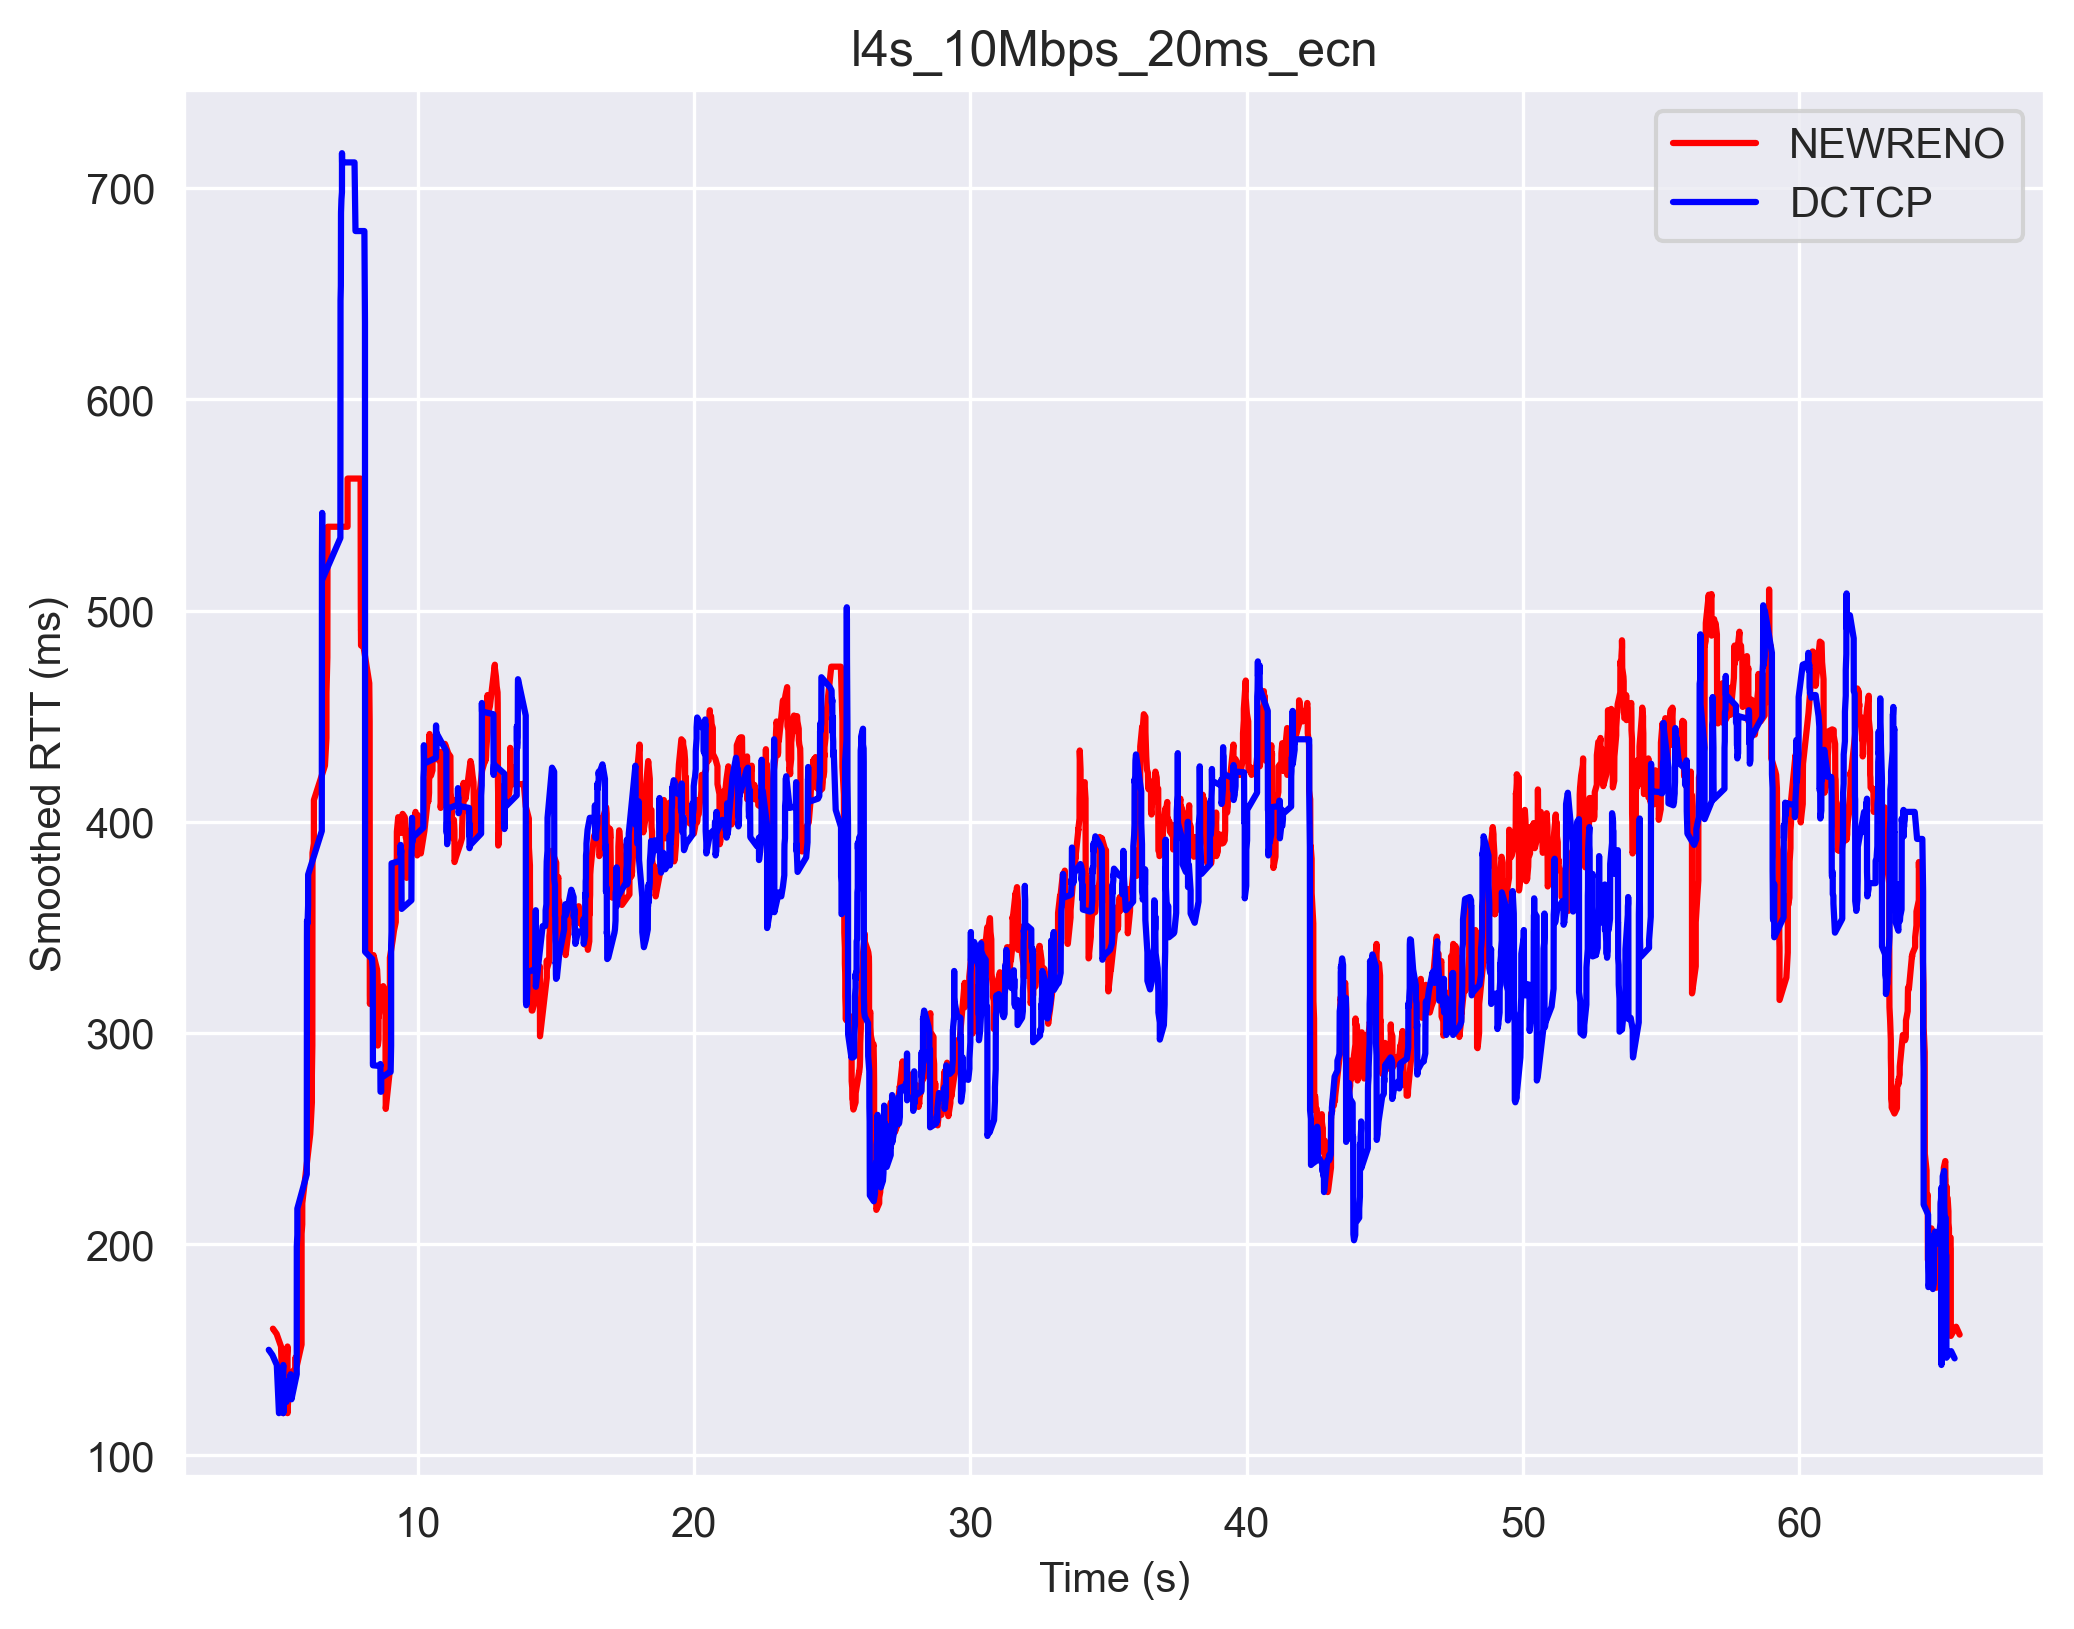

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


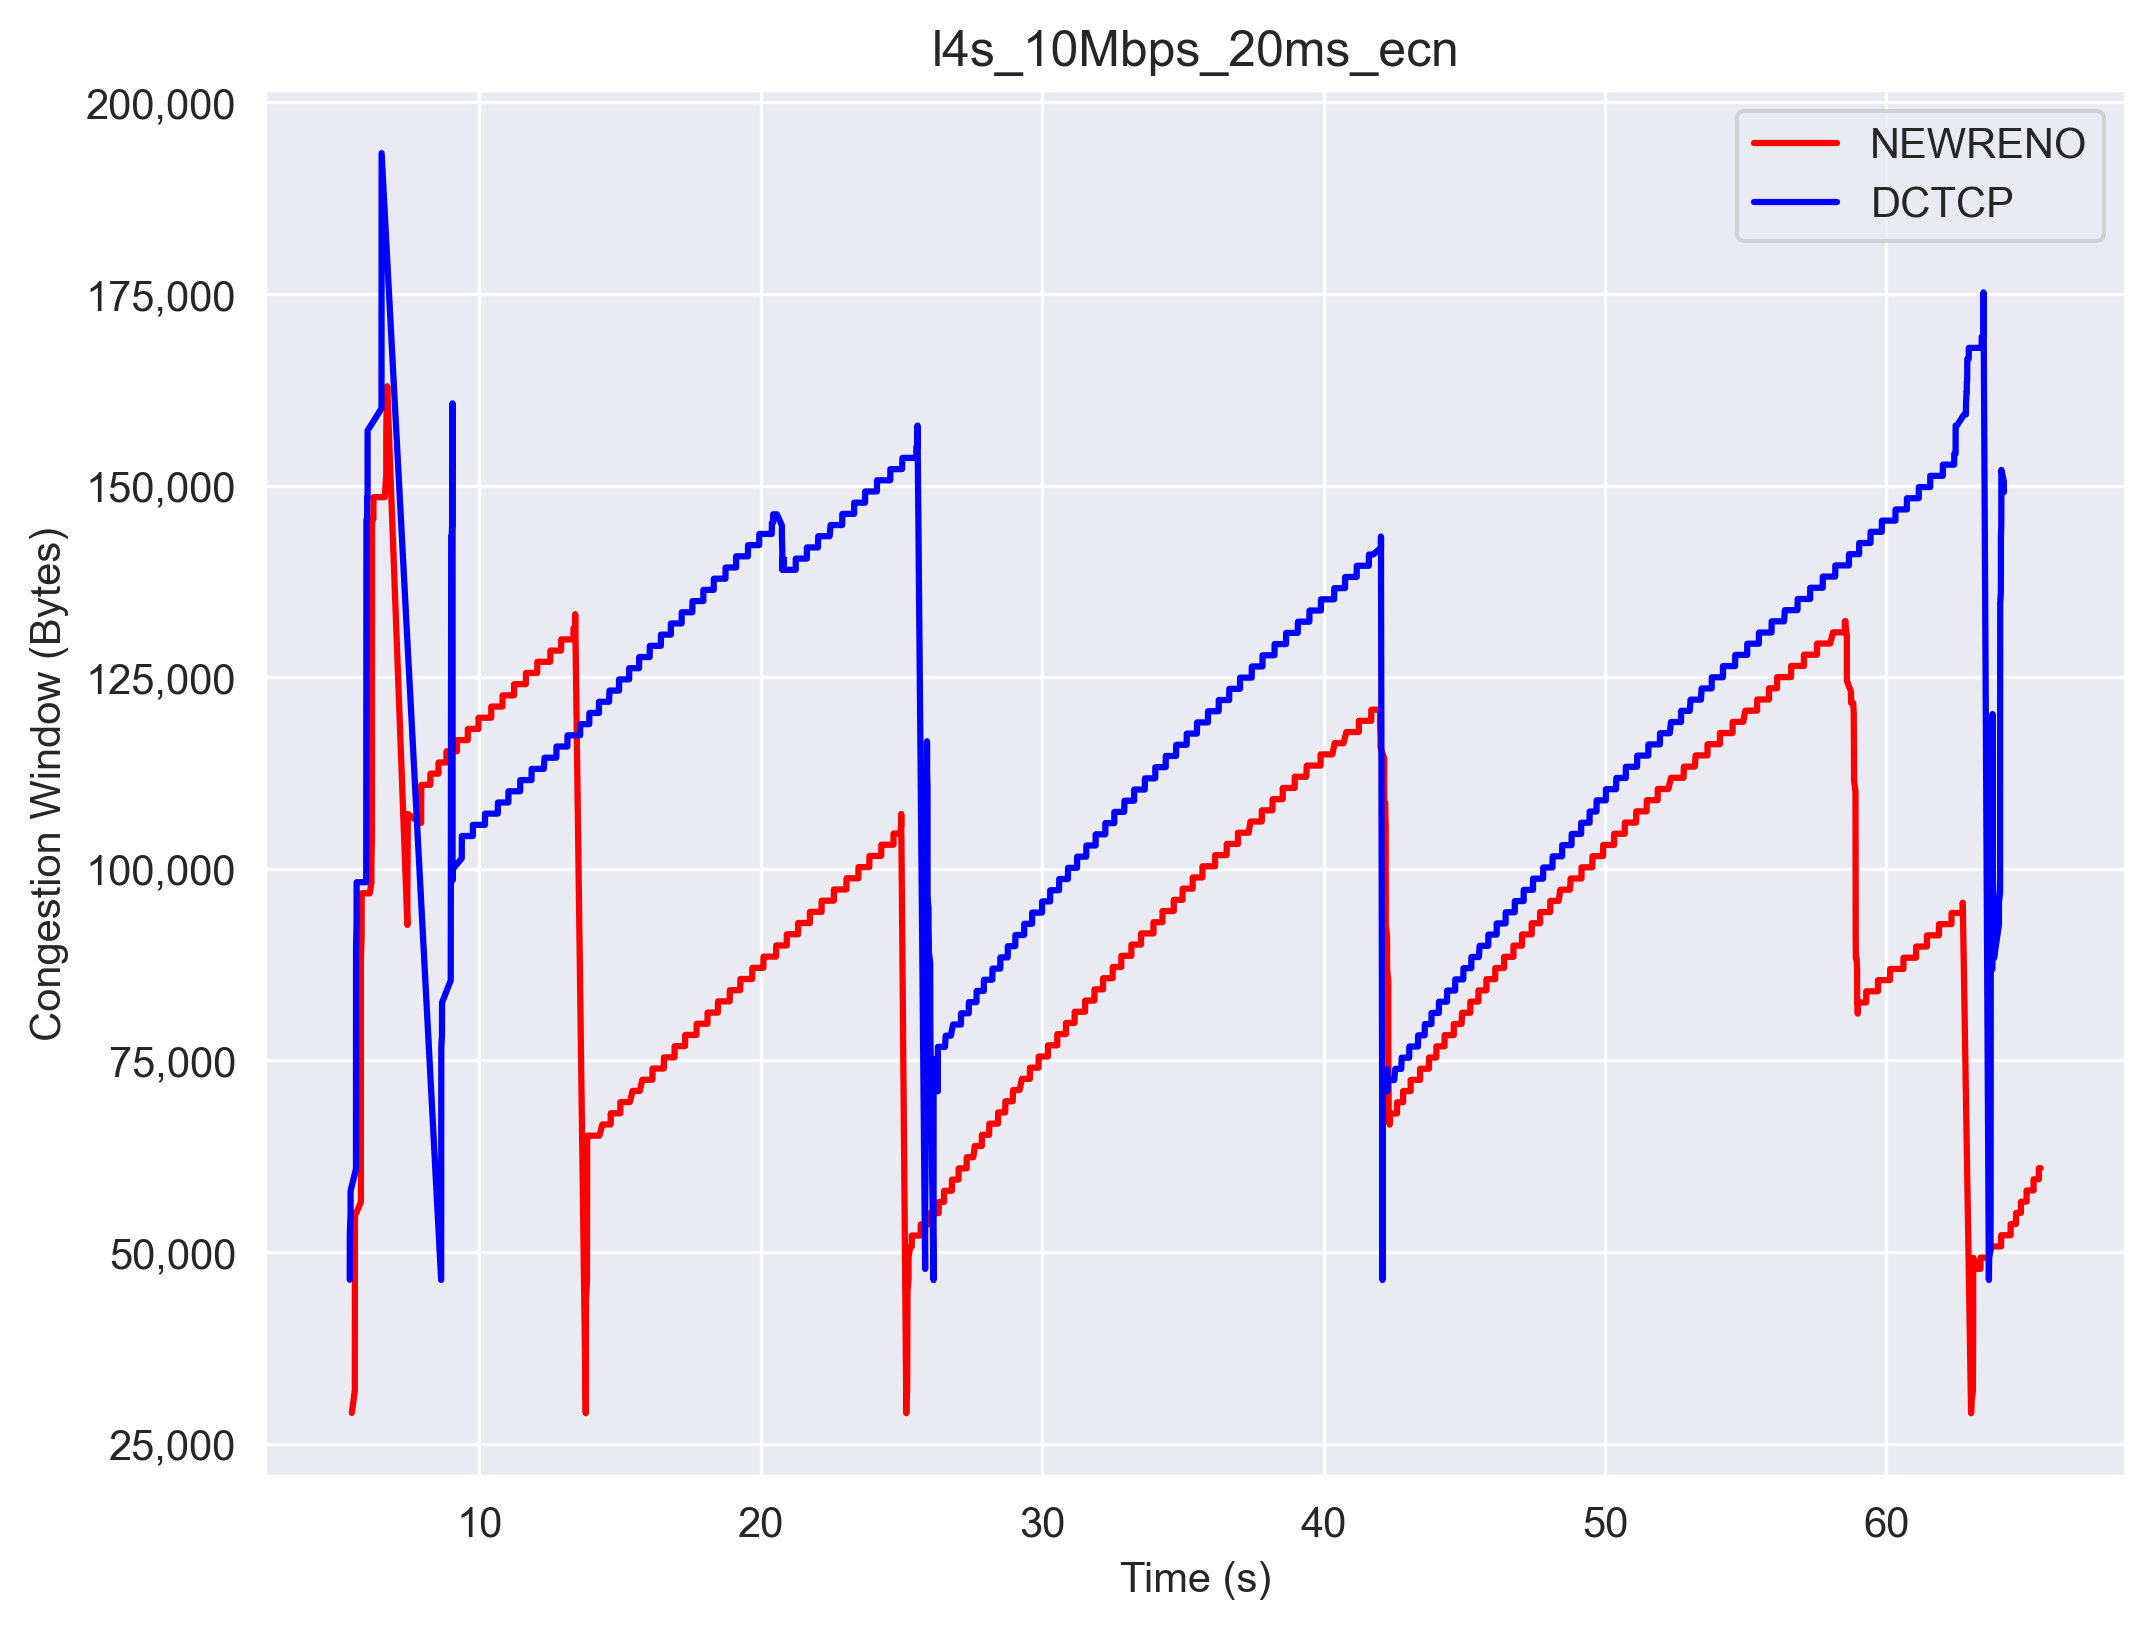

In [118]:
for scenario in unique_scenarios_dict:
    tcp1 = "CUBIC"
    tcp2 = "DCTCP"

    if "cubic" in unique_scenarios_dict[scenario][0] or "cubic" in unique_scenarios_dict[scenario][1]:
        tcp1 = "CUBIC"
    elif "newreno" in unique_scenarios_dict[scenario][0] or "newreno" in unique_scenarios_dict[scenario][1]:
        tcp1 = "NEWRENO"
    
    if "cubic" in unique_scenarios_dict[scenario][0] or "newreno" in unique_scenarios_dict[scenario][0]:
        dftcp1 = get_dataframe_from_filepath(unique_scenarios_dict[scenario][0])
        dftcp2 = get_dataframe_from_filepath(unique_scenarios_dict[scenario][1])
        print(f"{tcp1}-DCTCP")
    else:
        dftcp1 = get_dataframe_from_filepath(unique_scenarios_dict[scenario][1])
        dftcp2 = get_dataframe_from_filepath(unique_scenarios_dict[scenario][0])
        print(f"DCTCP-{tcp1}")

    # Define paths
    paths = {
        tcp1: dftcp1[dftcp1['ForeignPort'] == '5101'],
        tcp2: dftcp2[dftcp2['ForeignPort'] == '5102']
    }

    print("===============================================")
    print(tcp1)
    print(dftcp1[dftcp1['ForeignPort'] == '5101'].head())
    print("------------------------------------------------")
    print(tcp2)
    print(dftcp2[dftcp2['ForeignPort'] == '5101'].head())
    print("===============================================")






    # Calculate and save statistics
    stats_filename = f"{scenario}_statistics_results.txt"
    stats_directory = os.path.join(mainpth, "stats")
    print(stats_directory)
    file_path = manage_file(stats_filename, stats_directory)

    statistics = calculate_statistics(tcp1, tcp2, dftcp1, dftcp2, 'SmoothedRTT')
    save_statistics_to_file(file_path, statistics, scenario)
    print(f"Statistics saved to {file_path}")

    graph_directory = os.path.join(mainpth, "Graphs")
    create_directory_if_not_exists(graph_directory)

    # Plot Smoothed RTT vs Time
    plt.figure(figsize=(8, 6), dpi=300)
    sns.set_style("darkgrid")
    # if "10Mbps" in filenames[index]:
    #     plt.xlim(0,70)
    #     plt.ylim(0,8*100)
    # elif "1Mbps" in filenames[index]:
    #     plt.xlim(0,70)
    #     plt.ylim(0,8*100)

    # plt.ticklabel_format(style='sci', axis='x', scilimits=(0,0))




    for i, (title, path_df) in enumerate(paths.items()):
        print("i:,",i)
        print("colors[i]",colors[i])
        print("title",title)
        plt.plot(path_df['Time'], path_df['SmoothedRTT'], label=title, color=colors[i])
    plt.xlabel('Time (s)')
    plt.ylabel('Smoothed RTT (ms)')
    plt.title(scenario)
    plt.legend()
    plt.grid(True)
    plt.savefig(f"{graph_directory}/{scenario}_SmoothedRTT.png", dpi=300, bbox_inches='tight')
    plt.savefig(f"{graph_directory}/{scenario}_SmoothedRTT.eps", dpi=300, bbox_inches='tight')
    plt.show()

    # Filter outliers for CongestionWindow
    for title in paths.keys():
        paths[title] = remove_outliers_iqr(paths[title], 'CongestionWindow')

    # Plot Congestion Window vs Time
    plt.figure(figsize=(8, 6), dpi=300)
    sns.set_style("darkgrid")
    for i, (title, path_df) in enumerate(paths.items()):
        plt.plot(path_df['Time'], path_df['CongestionWindow'], label=title, color=colors[i])
    plt.gca().yaxis.set_major_formatter(ticker.FuncFormatter(comma_format))
    plt.xlabel('Time (s)')
    plt.ylabel('Congestion Window (Bytes)')
    plt.title(scenario)
    plt.legend()
    plt.grid(True)
    plt.savefig(f"{graph_directory}/{scenario}_CWND.png", dpi=300, bbox_inches='tight')
    plt.savefig(f"{graph_directory}/{scenario}_CWND.eps", dpi=300, bbox_inches='tight')
    plt.show()



In [119]:
# # Main processing loop
# for index in range(len(filenames)):
#     df=get_dataframe_from_filepath(filepaths[index])

#     # Define paths
#     paths = {
#         'TCP NEWRENO': df[df['ForeignPort'] == '5101'],
#         'TCP DCTCP': df[df['ForeignPort'] == '5102']
#     }

#     # Calculate and save statistics
#     stats_filename = f"./stats/{filenames[index]}_statistics_results.txt"
#     for title, path_df in paths.items():
#         statistics = calculate_statistics(path_df, 'SmoothedRTT')
#         save_statistics_to_file(stats_filename, statistics, title)
#         print(f"Statistics saved to {stats_filename}")

#     # Plot Smoothed RTT vs Time
#     plt.figure(figsize=(8, 6), dpi=300)
#     sns.set_style("darkgrid")
#     if "10Mbps" in filenames[index]:
#         plt.xlim(0,70)
#         plt.ylim(0,8*100)
#     elif "1Mbps" in filenames[index]:
#         plt.xlim(0,70)
#         plt.ylim(0,8*100)
#     # plt.ticklabel_format(style='sci', axis='x', scilimits=(0,0))
#     for i, (title, path_df) in enumerate(paths.items()):
#         print("i:,",i)
#         print("colors[i]",colors[i])
#         plt.plot(path_df['Time'], path_df['SmoothedRTT'], label=title, color=colors[i])
#     plt.xlabel('Time (s)')
#     plt.ylabel('Smoothed RTT (ms)')
#     plt.title(filenames[index])
#     plt.legend()
#     plt.grid(True)
#     plt.savefig(f"./Graphs/{filenames[index]}_SmoothedRTT.png", dpi=300, bbox_inches='tight')
#     plt.savefig(f"./Graphs/{filenames[index]}_SmoothedRTT.eps", dpi=300, bbox_inches='tight')
#     plt.show()

#     # Filter outliers for CongestionWindow
#     for title in paths.keys():
#         paths[title] = remove_outliers_iqr(paths[title], 'CongestionWindow')

#     # Plot Congestion Window vs Time
#     plt.figure(figsize=(8, 6), dpi=300)
#     sns.set_style("darkgrid")
#     for i, (title, path_df) in enumerate(paths.items()):
#         plt.plot(path_df['Time'], path_df['CongestionWindow'], label=title, color=colors[i])
#     plt.gca().yaxis.set_major_formatter(ticker.FuncFormatter(comma_format))
#     plt.xlabel('Time (s)')
#     plt.ylabel('Congestion Window (Bytes)')
#     plt.title(filenames[index])
#     plt.legend()
#     plt.grid(True)
#     plt.savefig(f"./Graphs/{filenames[index]}_CWND.png", dpi=300, bbox_inches='tight')
#     plt.savefig(f"./Graphs/{filenames[index]}_CWND.eps", dpi=300, bbox_inches='tight')
#     plt.show()


In [120]:
# dataframe_list=[]
# data_filename_list=[]
# data_dict={}
# for index in range(len(filenames)):
#     # open d:/work/mptcp/twopathMPdata/test1/twopathtype1.siftr.log
#     data = []
#     with open(filepaths[index], 'r') as f:
#         # store the data
#         for line in f:
#             tem = re.sub(r'\s', '', line)
#             data.append(tem.split(','))
#     # remove file line of data
#     print(filenames[index])
#     data.pop(0)
#     data.pop(len(data)-1)


#     enable_time_secs = 1716792031
#     enable_time_usecs = 61770
#     siftver = '1.3.0'
#     sysname = 'FreeBSD'
#     sysver = 1301000
#     ipmode = 4



#     df = pd.DataFrame(data, columns=col)

#     df=df[df['Direction']=='o']

#     # congestion window to int
#     df = df.astype({'CongestionWindow': 'int32'})
    
#     # Convert 'Time' column to float64 type
#     df['Time'] = df['Time'].astype('float64')

#     # Subtract the first time entry from all the entries in 'Time' column
#     df['Time'] = df['Time'] - df['Time'].iloc[0]



#     # remove rows that congestion window bigger than 70000
#     # df = df[df['CongestionWindow'].astype(int) < 70000]
#     # RTT divide by tcp_rtt_scale * hz
#     df['SmoothedRTT'] = df['SmoothedRTT'].astype('float64')
#     df['SmoothedRTT'] = (df['SmoothedRTT'] / 1000)
#     df['SmoothedRTT'] = df['SmoothedRTT'].astype('float64')

    



#     # first path ForeignPort = 5101
#     dfPath1 = df.loc[(df['ForeignPort'] == '5101')]

#     # second path localip = 5102
#     dfPath2 = df.loc[(df['ForeignPort'] == '5102')]

#     # third path ForeignPort = 5101
#     dfPath3 = df.loc[(df['ForeignPort'] == '5103' )]

#     # fourth path localip = 5102
#     dfPath4 = df.loc[(df['ForeignPort'] == '5104')]
    
#     # data_filename_list.append(filenames[index])
#     # dataframe_list.append(dfPath1.copy())
#     # data_dict[filenames[index]]=dfPath1.copy()
#     print(dfPath4['SmoothedRTT'].describe())
#     print(dfPath4['SmoothedRTT'].head(5))
#     print(dfPath4['SmoothedRTT'].tail(5))

#     # Darker color-blind-friendly palette
#     colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728']
#     # Different line styles and markers
#     line_styles = ['-', '--', '-.', ':']
#     #line_styles = ['-', '-', '-', '-']
#     markers = ['o', 's', '^', 'D']

    


    

#     # Plot Smoothed RTT vs Time
#     #plt.figure(figsize=(7, 4.5))  # Set the figure size to fit within the column width
#     plt.rcParams.update({'figure.figsize':(8,6), 'figure.dpi':300, 'font.size':20})
#     sns.set_style("darkgrid")  # Set the style to darkgrid

#     # if "10Mbps" in filenames[index]:
#     #     plt.xlim(0,100)
#     #     plt.ylim(0,1*100)
#     # elif "1Mbps" in filenames[index]:
#     #     plt.xlim(0,100)
#     #     plt.ylim(0,1.5*100)
#     # if "fq_codel_10Mbps_20ms_ecn" in filenames[index]:
#     #     plt.xlim(0,100)
#     #     plt.ylim(0,2.7*100)
#     #     # plt.ticklabel_format(style='sci', axis='x', scilimits=(0,0))
#     # if "fq_codel_1Mbps_20ms_ecn" in filenames[index]:
#     #     plt.xlim(0,100)
#     #     plt.ylim(0,5.2*100)
#     #     # plt.ticklabel_format(style='sci', axis='x', scilimits=(0,0))

    
#     # plt.plot(dfPath1['Time'], dfPath1['SmoothedRTT'], label='TCP Stream 1',
#     #              color=colors[0], linestyle=line_styles[0])
#     # plt.plot(dfPath2['Time'], dfPath2['SmoothedRTT'], label='TCP Stream 2',
#     #              color=colors[1], linestyle=line_styles[1])
#     # plt.plot(dfPath3['Time'], dfPath3['SmoothedRTT'], label='TCP Stream 3',
#     #              color=colors[2], linestyle=line_styles[2])
#     # plt.plot(dfPath4['Time'], dfPath4['SmoothedRTT'], label='TCP Stream 4',
#     #              color=colors[3], linestyle=line_styles[3])
#     # Function to calculate statistics
#     def calculate_statistics(df):
#         median = df['SmoothedRTT'].median()
#         mean = df['SmoothedRTT'].mean()
#         q25 = df['SmoothedRTT'].quantile(0.25)
#         q75 = df['SmoothedRTT'].quantile(0.75)
#         minimum = df['SmoothedRTT'].min()
#         maximum = df['SmoothedRTT'].max()
        
#         return {
#             'Median': median,
#             'Mean': mean,
#             '25th Percentile': q25,
#             '75th Percentile': q75,
#             'Minimum': minimum,
#             'Maximum': maximum
#         }

#     # Calculate statistics for each DataFrame
#     statistics_dfPath1 = calculate_statistics(dfPath1)
#     statistics_dfPath2 = calculate_statistics(dfPath2)
#     statistics_dfPath3 = calculate_statistics(dfPath3)
#     statistics_dfPath4 = calculate_statistics(dfPath4)

#     # Define the filename to save results
#     stats_filename = "./stats/"+filenames[index]+'_statistics_results.txt'

#     # Function to save statistics to a file
#     def save_statistics_to_file(stats_filename, statistics,title):
#         with open(stats_filename, 'a') as f:
#             f.write("Statistics for "+title+":\n")
#             for key, value in statistics.items():
#                 f.write(f"{key}: {value}\n")
#             f.write("\n")

#     # Save statistics for each DataFrame to the file
#     save_statistics_to_file(stats_filename, statistics_dfPath1, "TCP Stream 1")
#     save_statistics_to_file(stats_filename, statistics_dfPath2, "TCP Stream 2")
#     save_statistics_to_file(stats_filename, statistics_dfPath3, "TCP Stream 3")
#     save_statistics_to_file(stats_filename, statistics_dfPath4, "TCP Stream 4")

#     print(f"Statistics saved to {stats_filename}")
    
#     plt.plot(dfPath1['Time'], dfPath1['SmoothedRTT'], label='TCP Stream 1',
#                  color=colors[0])
#     plt.plot(dfPath2['Time'], dfPath2['SmoothedRTT'], label='TCP Stream 2',
#                  color=colors[1])
#     plt.plot(dfPath3['Time'], dfPath3['SmoothedRTT'], label='TCP Stream 3',
#                  color=colors[2])
#     plt.plot(dfPath4['Time'], dfPath4['SmoothedRTT'], label='TCP Stream 4',
#                  color=colors[3])
    
#     plt.xlabel('Time (s)')
#     plt.ylabel('Smoothed RTT (ms)')
#     plt.title(filenames[index])
#     plt.legend()
#     plt.grid(True)
#     # plt.savefig("./iperf3_tests/"+title+"-"+"Graphs.png", dpi=100,bbox_inches='tight')
#     plt.savefig("./Graphs/"+filenames[index]+"_SmoothedRTT.png", dpi=300,bbox_inches='tight')
#     plt.savefig("./Graphs/"+filenames[index]+"_SmoothedRTT.eps", dpi=300,bbox_inches='tight')
#     plt.show()

#     dfpath1_filtered = remove_outliers_iqr(dfPath1,"CongestionWindow")
#     dfpath2_filtered = remove_outliers_iqr(dfPath2,"CongestionWindow")
#     dfpath3_filtered = remove_outliers_iqr(dfPath3,"CongestionWindow")
#     dfpath4_filtered = remove_outliers_iqr(dfPath4,"CongestionWindow")

#     # Plot CWND vs Time
#     #plt.figure(figsize=(7, 4.5))  # Set the figure size to fit within the column width
#     plt.rcParams.update({'figure.figsize':(8,6), 'figure.dpi':300, 'font.size':20})
#     sns.set_style("darkgrid")  # Set the style to darkgrid


#     # if contains_1_or_2(filenames[index]) == 1:
#     #     plt.xlim(0,100)
#     #     plt.ylim(0,140000)
#     # elif contains_1_or_2(filenames[index]) == 2:
#     #     plt.xlim(0,100)
#     #     plt.ylim(0,140000)

#     # if "10Mbps" in filenames[index]:
#     #     plt.xlim(0,100)
#     #     plt.ylim(0,180000)
#     # elif "1Mbps" in filenames[index] and "pie_1Mbps_20ms_ecn" not in filenames[index] and "codel_1Mbps_20ms_ecn" not in filenames[index]:
#     #     plt.xlim(0,100)
#     #     plt.ylim(0,35000)
#     # if "fq_codel_10Mbps_20ms_ecn" in filenames[index]:
#     #     # plt.xlim(0,100)
#     #     # plt.ylim(0,2.7)
#     #     plt.ticklabel_format(style='sci', axis='y', scilimits=(0,0))
#     # if "fq_codel_1Mbps_20ms_ecn" in filenames[index]:
#     #     # plt.xlim(0,100)
#     #     # plt.ylim(0,4.2)
#     #     plt.ticklabel_format(style='sci', axis='y', scilimits=(0,0))
    

    

    
   
#     plt.plot(dfpath1_filtered['Time'], dfpath1_filtered['CongestionWindow'], label='TCP Stream 1',
#                  color=colors[0])
#     plt.plot(dfpath2_filtered['Time'], dfpath2_filtered['CongestionWindow'], label='TCP Stream 2',
#                  color=colors[1])
#     plt.plot(dfpath3_filtered['Time'], dfpath3_filtered['CongestionWindow'], label='TCP Stream 3',
#                  color=colors[2])
#     plt.plot(dfpath4_filtered['Time'], dfpath4_filtered['CongestionWindow'], label='TCP Stream 4',
#                  color=colors[3])
#     import matplotlib.ticker as ticker
#     # Format y-axis labels with commas
#     def comma_format(x, pos):
#         return f'{int(x):,}'

#     plt.gca().yaxis.set_major_formatter(ticker.FuncFormatter(comma_format))



#     # from matplotlib.ticker import ScalarFormatter
    
#     # colors = ['blue', 'green', 'red', 'purple']

#     # fig, ax = plt.subplots()

#     # ax.plot(dfpath1_filtered['Time'], dfpath1_filtered['CongestionWindow'], label='TCP Stream 1')
#     # ax.plot(dfpath2_filtered['Time'], dfpath2_filtered['CongestionWindow'], label='TCP Stream 2')
#     # ax.plot(dfpath3_filtered['Time'], dfpath3_filtered['CongestionWindow'], label='TCP Stream 3')
#     # ax.plot(dfpath4_filtered['Time'], dfpath4_filtered['CongestionWindow'], label='TCP Stream 4')

#     # # Use scientific notation in the form of 10^x
#     # formatter = ScalarFormatter(useMathText=True)
#     # formatter.set_scientific(True)
#     # formatter.set_powerlimits((0, 0))
#     # ax.yaxis.set_major_formatter(formatter)

#     # plt.ticklabel_format(style='sci', axis='y', scilimits=(0,0))

    
#     plt.xlabel('Time (s)')
#     plt.ylabel('Congestion Window (Bytes)')
#     plt.title(filenames[index])
#     plt.legend()
#     plt.grid(True)
#     # plt.savefig("./iperf3_tests/"+title+"-"+"Graphs.png", dpi=100,bbox_inches='tight')
#     plt.savefig("./Graphs/"+filenames[index]+"_CWND.png", dpi=300,bbox_inches='tight')
#     plt.savefig("./Graphs/"+filenames[index]+"_CWND.eps", dpi=300,bbox_inches='tight')
#     plt.show()
    


In [121]:
for i in range(len(col)):
    print(i,end=",")
    print(col[i])


0,Direction
1,Time
2,LocalIP
3,LocalPort
4,ForeignIP
5,ForeignPort
6,SlowStartThreshold
7,CongestionWindow
8,BandwidthControlledWindow
9,SendingWindow
10,ReceiveWindow
11,SendingWindowScalingFactor
12,ReceiveWindowScalingFactor
13,TCPFiniteStateMachine
14,MaximumSegmentSize
15,SmoothedRTT
16,SACKEnabled
17,TCPFlags
18,RetransmissionTimeout
19,SocketSendBufferSize
20,SocketSendBufferBytes
21,SocketReceiveBufferSize
22,SocketReceiveBufferBytes
23,UnacknowledgedBytes
24,ReassemblyQueue
25,Flowid
26,Flowtype
